In [1]:
## Python 3.8.16
# ! pip install matplotlib
# ! pip install pandas
# ! pip install seaborn
# ! pip install -U pip setuptools wheel
# ! pip install -U 'spacy[cuda-autodetect]'
# ! python -m spacy download es_core_news_sm
# ! pip install spacy-cleaner
# ! pip install ydata-profiling

In [1]:
%matplotlib inline
import spacy
import numpy as np
import pandas as pd
import spacy_cleaner
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from ydata_profiling import ProfileReport
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy_cleaner.processing import removers, replacers, mutators
pd.options.mode.chained_assignment = None

/home/oscar/anaconda3/envs/text/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Análisis exploratorio marketplace

Los datos vienen con un pequeño tratamiento para extraer campos de columnas con doble valor, posteriormente a este análisis se complementara esta parte, en esta etapa se dará prioridad a la velocidad y posteriormente en el código 
de ETL se refinara el código para poder replicar con otros conjuntos de datos los archivos, por otro lado los resultados de EDA se ecuentran en los archivos: **output_initial.html**, **output_clean.html** y **output_initial.html**, del directorio raíz de este repositorio 

In [2]:
FOLDER = "/home/oscar/GitHub/test_used_tl_ML/data/"

In [3]:
df = pd.read_csv(FOLDER + "train.csv", index_col=0)
df = df.reset_index(drop=True)

/tmp/ipykernel_19968/1023102910.py:1: DtypeWarning: Columns (6,10,14,24,25,26,30,32,38,41,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FOLDER + "train.csv", index_col=0)


In [4]:
print(f"Cantidad de variables {len(df.columns)}, cantidad de observaciones {len(df)}")

Cantidad de variables 47, cantidad de observaciones 100003


### Perfilado inicial

In [6]:
profile = ProfileReport(df, minimal=True)
profile.to_file("output_initial.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 334.45it/s]


En esta parte se definen las variables mas importantes según el análisis del perfilador utilizado, en la parte siguiente de este informe solo se trataran las variables que tiene una cardinalidad baja, que el desequilibrio en las clases no sea mayor al 50% y que los valores faltantes no superen el 10%, así mismo las variables no soportadas se les hará un tratamiento de limpieza mas admitido y al final se compararan los dos análisis

### Limpieza posterior de las variables no soportadas

#### Variable seller_id

In [5]:
df["seller_id"].head()

0    8208882349
1    8141699488
2    8386096505
3    5377752182
4    2938071313
Name: seller_id, dtype: object

In [6]:
df["seller_id"].describe()

count          99999
unique         43154
top       5248662274
freq             618
Name: seller_id, dtype: int64

**Nota:** Esta columna para ce que para el objetivo del análisis de determinar si el carro ofrecido es nuevo o usado para ce que tiene poco valor ya que es un identificador de usuario, pero para campañas de marketing de los 90.000 datos analizados hay únicos 39.432, es decir que hay una población de vendedores por lo menos de mas de una venta, se procede a eliminar del análisis preliminar

In [7]:
na_seller_id = df[df["seller_id"].isnull() == True]
na_seller_id

warranty sub_status condition deal_ids  \
16693  Envios a capital federal $26.        NaN       NaN      NaN   
83019           4 meses de Garantía         NaN       NaN      NaN   
83841   Envios capital federeal $26.        NaN       NaN      NaN   
93111  Envios a capital federal $33.        NaN       NaN      NaN   

       base_price seller_id variations site_id listing_type_id price  ...  \
16693         NaN       NaN        NaN     NaN             NaN   NaN  ...   
83019         NaN       NaN        NaN     NaN             NaN   NaN  ...   
83841         NaN       NaN        NaN     NaN             NaN   NaN  ...   
93111         NaN       NaN        NaN     NaN             NaN   NaN  ...   

      start_time permalink sold_quantity available_quantity  \
16693        NaN       NaN           NaN                NaN   
83019        NaN       NaN           NaN                NaN   
83841        NaN       NaN           NaN                NaN   
93111        NaN       NaN           NaN                NaN   

      seller_address_country_name seller_address_state_name  \
16693                         NaN                       NaN   
83019                         NaN                       NaN   
83841                         NaN                       NaN   
93111                         NaN                       NaN   

      seller_address_city_name shipping_local_pick_up shipping_free_shipping  \
16693                      NaN                    NaN                    NaN   
83019                      NaN                    NaN                    NaN   
83841                      NaN                    NaN                    NaN   
93111                      NaN                    NaN                    NaN   

         Y  
16693  NaN  
83019  NaN  
83841  NaN  
93111  NaN  

[4 rows x 47 columns]

In [8]:
na_seller_id = list(na_seller_id.index)

In [9]:
df = df.drop(na_seller_id, axis=0)

In [10]:
df = df.drop("seller_id", axis=1)

#### Variable price

In [11]:
df["price"].tail()

99998     417.99
99999       30.0
100000     239.0
100001     600.0
100002      50.0
Name: price, dtype: object

In [12]:
df["price"].describe()

count     99999.0
unique    12824.0
top          50.0
freq       2172.0
Name: price, dtype: float64

In [13]:
na_price = df[df["price"].isnull() == True]
na_price

Empty DataFrame
Columns: [warranty, sub_status, condition, deal_ids, base_price, variations, site_id, listing_type_id, price, attributes, buying_mode, tags, listing_source, parent_item_id, coverage_areas, category_id, descriptions, last_updated, international_delivery_mode, pictures, id, official_store_id, differential_pricing, accepts_mercadopago, original_price, currency_id, thumbnail, title, automatic_relist, date_created, stop_time, status, video_id, catalog_product_id, subtitle, initial_quantity, start_time, permalink, sold_quantity, available_quantity, seller_address_country_name, seller_address_state_name, seller_address_city_name, shipping_local_pick_up, shipping_free_shipping, Y]
Index: []

[0 rows x 46 columns]

In [14]:
df["temp_column_price"] = df["price"].apply(lambda x: type(x) != float)

In [15]:
type(df["price"][df["temp_column_price"] == True].iloc[0])

str

In [16]:
for i in range(len(df)):
    if df["temp_column_price"].iloc[i] == True:
        try:
            df["price"].iloc[i] = float(df["price"].iloc[i])
        except:
            df["price"].iloc[i] = float("nan")

In [17]:
na_price = df[df["price"].isnull() == True]
na_price

warranty sub_status condition deal_ids    base_price variations site_id  \
16694       []       used        []     80.0  9.357516e+09        MLA  bronze   
83020       []        new        []   5500.0  8.714872e+09        MLA  bronze   
83842       []        new        []    100.0  9.357516e+09        MLA  bronze   
93112       []       used        []     70.0  9.357516e+09        MLA  bronze   

      listing_type_id price  attributes  ... permalink sold_quantity  \
16694            80.0   NaN  buy_it_now  ...         0           1.0   
83020          5500.0   NaN  buy_it_now  ...         0           1.0   
83842           100.0   NaN  buy_it_now  ...         0           1.0   
93112            70.0   NaN  buy_it_now  ...         0           1.0   

      available_quantity seller_address_country_name  \
16694          Argentina             Capital Federal   
83020          Argentina             Capital Federal   
83842          Argentina             Capital Federal   
93112          Argentina             Capital Federal   

      seller_address_state_name seller_address_city_name  \
16694                tribunales                    False   
83020                   Almagro                    False   
83842                tribunales                     True   
93112                tribunales                    False   

      shipping_local_pick_up shipping_free_shipping    Y temp_column_price  
16694                  False                   used  NaN              True  
83020                  False                    new  NaN              True  
83842                  False                    new  NaN              True  
93112                  False                   used  NaN              True  

[4 rows x 47 columns]

In [18]:
na_price = list(na_price.index)

In [19]:
df = df.drop(na_price, axis=0)

In [20]:
max(df["price"]), min(df["price"])

(2222222222.0, 0.84)

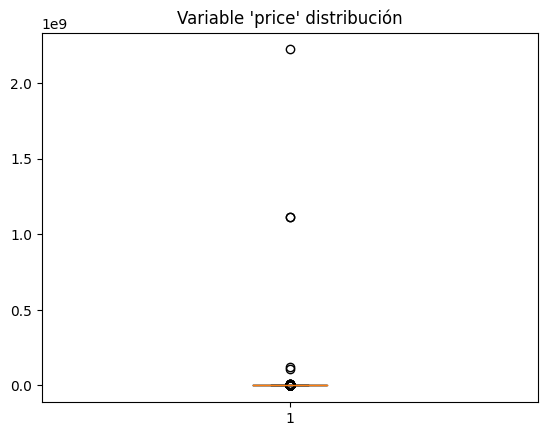

In [21]:
plt.boxplot(df["price"])
plt.title("Variable 'price' distribución")
plt.show()

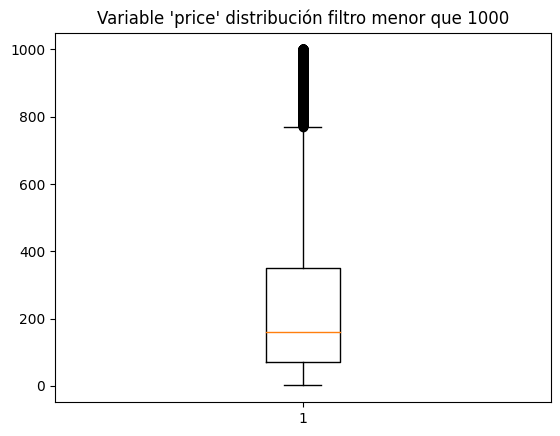

In [22]:
plt.boxplot(df["price"][df["price"] < 1000])
plt.title("Variable 'price' distribución filtro menor que 1000")
plt.show()

In [23]:
len(df["price"][df["price"] < 10000])

95955

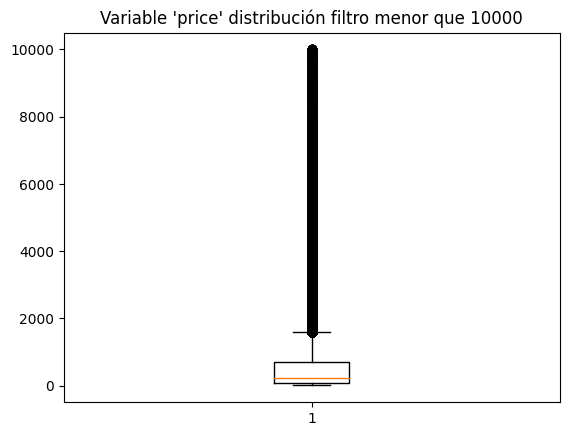

In [24]:
plt.boxplot(df["price"][df["price"] < 10000])
plt.title("Variable 'price' distribución filtro menor que 10000")
plt.show()

In [25]:
(1 - len(df["price"][df["price"] < 10000]) / len(df)) * 100

4.0402020101005025

**Nota :** Esta columna presenta varios valore atípicos por esta razón se procede a eliminar los valores que estén por encima de 100.000, perdiendo solo el 4% de los datos originales, al valor mayor es de 2.222.222.222 que es muy atípico

In [26]:
df = df[df["price"] < 10000]

In [27]:
len(df)

95955

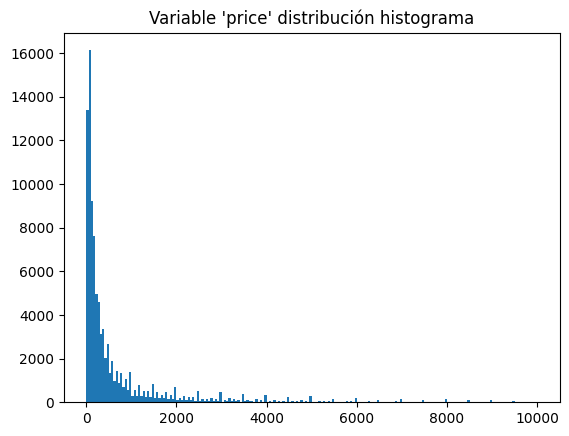

In [28]:
plt.hist(df["price"], bins=200)
plt.title("Variable 'price' distribución histograma")
plt.show()

#### Variable original price

In [29]:
df["original_price"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: original_price, dtype: object

In [30]:
na_original_price = df[df["original_price"].isnull() == True]
na_original_price

warranty sub_status  \
0                                                     NaN         []   
1                                      NUESTRA REPUTACION         []   
2                                                     NaN         []   
3                                                     NaN         []   
4                                          MI REPUTACION.         []   
...                                                   ...        ...   
99998                                                  SI         []   
99999                                                 NaN         []   
100000                                                NaN         []   
100001                                                NaN         []   
100002  Buen estado, se verifica al entregar. la total...         []   

       condition deal_ids  base_price  \
0            new       []       80.00   
1           used       []     2650.00   
2           used       []       60.00   
3            new       []      580.00   
4           used       []       30.00   
...          ...      ...         ...   
99998        new       []      417.99   
99999       used       []       30.00   
100000       new       []      239.00   
100001      used       []      600.00   
100002      used       []       50.00   

                                               variations site_id  \
0                                                      []     MLA   
1                                                      []     MLA   
2                                                      []     MLA   
3                                                      []     MLA   
4                                                      []     MLA   
...                                                   ...     ...   
99998                                                  []     MLA   
99999                                                  []     MLA   
100000                                                 []     MLA   
100001  [{'attribute_combinations': [{'value_id': '920...     MLA   
100002                                                 []     MLA   

       listing_type_id   price  \
0               bronze    80.0   
1               silver  2650.0   
2               bronze    60.0   
3               silver   580.0   
4               bronze    30.0   
...                ...     ...   
99998           bronze  417.99   
99999             free    30.0   
100000          bronze   239.0   
100001          bronze   600.0   
100002          bronze    50.0   

                                               attributes  ...  \
0                                                      []  ...   
1                                                      []  ...   
2                                                      []  ...   
3                                                      []  ...   
4                                                      []  ...   
...                                                   ...  ...   
99998                                                  []  ...   
99999                                                  []  ...   
100000                                                 []  ...   
100001  [{'value_id': 'male', 'attribute_group_id': 'D...  ...   
100002                                                 []  ...   

                                                permalink sold_quantity  \
0       http://articulo.mercadolibre.com.ar/MLA4695330...           0.0   
1       http://articulo.mercadolibre.com.ar/MLA7160447...           0.0   
2       http://articulo.mercadolibre.com.ar/MLA7367189...           0.0   
3       http://articulo.mercadolibre.com.ar/MLA9191625...           0.0   
4       http://articulo.mercadolibre.com.ar/MLA7787961...           0.0   
...                                                   ...           ...   
99998   http://articulo.mercadolibre.com.ar/MLA4006670...           0.0   
99999   http://articulo.mercadolibre.com.ar/MLA7015262...   

**Nota:** Esta variable tiene todos su valores NA así que se procede a eliminar

In [31]:
df = df.drop(["original_price", "temp_column_price"], axis=1)

#### Variable automatic_relist

In [32]:
df["automatic_relist"].head()

0    False
1    False
2    False
3    False
4    False
Name: automatic_relist, dtype: object

In [33]:
df["automatic_relist"] = df["automatic_relist"].apply(lambda x: type(x) != bool)
for i in range(len(df)):
    if df["automatic_relist"].iloc[i] == True:
        try:
            df["automatic_relist"].iloc[i] = float(df["automatic_relist"].iloc[i])
        except:
            df["automatic_relist"].iloc[i] = float("nan")

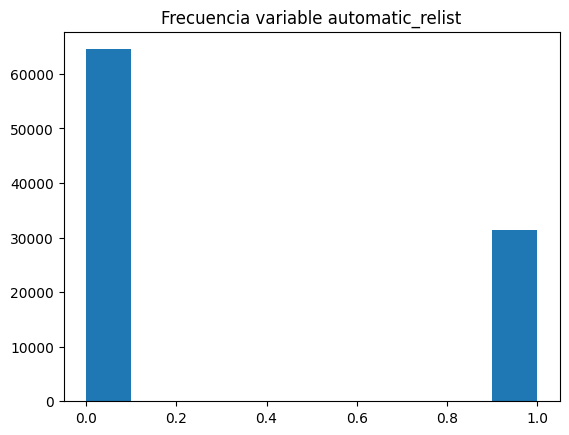

In [34]:
plt.hist(df["automatic_relist"])
plt.title("Frecuencia variable automatic_relist")
plt.show()

In [35]:
na_automatic_relist = df[df["automatic_relist"].isnull() == True]
na_automatic_relist

Empty DataFrame
Columns: [warranty, sub_status, condition, deal_ids, base_price, variations, site_id, listing_type_id, price, attributes, buying_mode, tags, listing_source, parent_item_id, coverage_areas, category_id, descriptions, last_updated, international_delivery_mode, pictures, id, official_store_id, differential_pricing, accepts_mercadopago, currency_id, thumbnail, title, automatic_relist, date_created, stop_time, status, video_id, catalog_product_id, subtitle, initial_quantity, start_time, permalink, sold_quantity, available_quantity, seller_address_country_name, seller_address_state_name, seller_address_city_name, shipping_local_pick_up, shipping_free_shipping, Y]
Index: []

[0 rows x 45 columns]

**Nota:** Esta variable esta des balanceada pero se tendrá en cuenta en el análisis inicial 

#### Variable stop_time y start_time

In [36]:
df["stop_time"].head()

0    1446669773000
1    1448474910000
2    1447027027000
3    1449191596000
4    1445638040000
Name: stop_time, dtype: object

In [37]:
df["start_time"].head()

0    1441485773000
1    1443290910000
2    1441843027000
3    1443466076000
4    1440454040000
Name: start_time, dtype: object

**Nota:** Esta variable es una marca de tiempo y el problema es de clasificación así que no se tendrán en cuenta y se eliminaran de este análisis

In [38]:
df = df.drop(["stop_time", "start_time"], axis=1)

#### Variable available_quantity

In [39]:
df["available_quantity"].head()

0    1
1    1
2    1
3    1
4    1
Name: available_quantity, dtype: object

In [40]:
df["available_quantity"] = df["available_quantity"].apply(lambda x: type(x) != int)
for i in range(len(df)):
    if df["available_quantity"].iloc[i] == True:
        try:
            df["available_quantity"].iloc[i] = float(df["available_quantity"].iloc[i])
        except:
            df["available_quantity"].iloc[i] = float("nan")

In [41]:
na_available_quantity = df[df["available_quantity"].isnull() == True]
na_available_quantity

Empty DataFrame
Columns: [warranty, sub_status, condition, deal_ids, base_price, variations, site_id, listing_type_id, price, attributes, buying_mode, tags, listing_source, parent_item_id, coverage_areas, category_id, descriptions, last_updated, international_delivery_mode, pictures, id, official_store_id, differential_pricing, accepts_mercadopago, currency_id, thumbnail, title, automatic_relist, date_created, status, video_id, catalog_product_id, subtitle, initial_quantity, permalink, sold_quantity, available_quantity, seller_address_country_name, seller_address_state_name, seller_address_city_name, shipping_local_pick_up, shipping_free_shipping, Y]
Index: []

[0 rows x 43 columns]

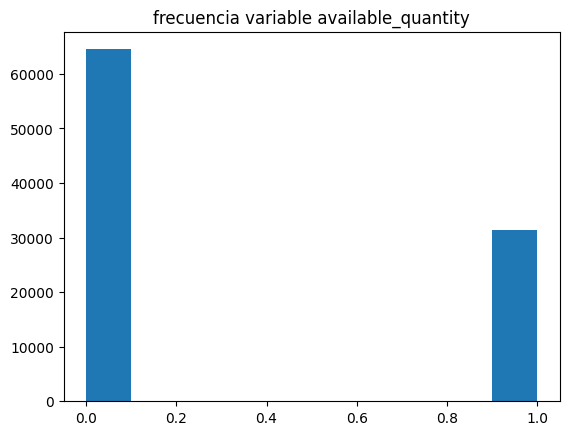

In [42]:
plt.hist(df["available_quantity"])
plt.title("frecuencia variable available_quantity")
plt.show()

**Nota:** Esta variable esta des balanceada pero se tendrá en cuenta en el análisis inicial 

#### Variable shipping_free_shipping

In [43]:
df["shipping_free_shipping"].head()

0    False
1    False
2    False
3    False
4    False
Name: shipping_free_shipping, dtype: object

In [44]:
df["shipping_free_shipping"] = df["shipping_free_shipping"].apply(lambda x: type(x) != int)
for i in range(len(df)):
    if df["shipping_free_shipping"].iloc[i] == True:
        try:
            df["shipping_free_shipping"].iloc[i] = float(df["shipping_free_shipping"].iloc[i])
        except:
            df["shipping_free_shipping"].iloc[i] = float("nan")

In [45]:
na_shipping_free_shipping = df[df["shipping_free_shipping"].isnull() == True]
na_shipping_free_shipping

Empty DataFrame
Columns: [warranty, sub_status, condition, deal_ids, base_price, variations, site_id, listing_type_id, price, attributes, buying_mode, tags, listing_source, parent_item_id, coverage_areas, category_id, descriptions, last_updated, international_delivery_mode, pictures, id, official_store_id, differential_pricing, accepts_mercadopago, currency_id, thumbnail, title, automatic_relist, date_created, status, video_id, catalog_product_id, subtitle, initial_quantity, permalink, sold_quantity, available_quantity, seller_address_country_name, seller_address_state_name, seller_address_city_name, shipping_local_pick_up, shipping_free_shipping, Y]
Index: []

[0 rows x 43 columns]

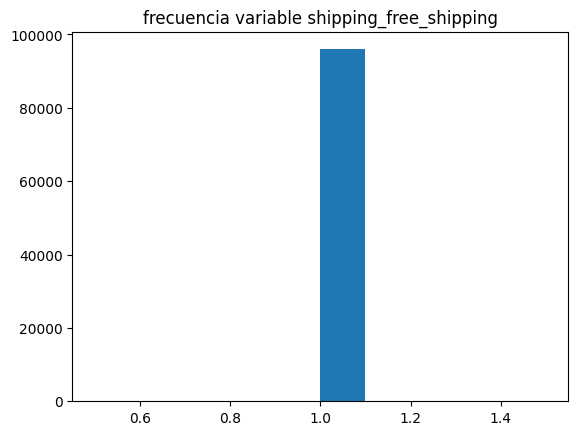

In [46]:
plt.hist(df["shipping_free_shipping"])
plt.title("frecuencia variable shipping_free_shipping")
plt.show()

**Nota:** Esta variable tiene todos su valores igual a 1 así que se procede a eliminar

In [47]:
df = df.drop(["shipping_free_shipping"], axis=1)

#### Variable warranty

Esta es una variable de tipo categórica, pero se quiere mejorar su desempeño con algo de tratamiento de texto, transformando todo el texto a minúscula y quitando los acentos con el fin de reducir las categorías

In [48]:
df["warranty"] = df["warranty"].apply(lambda x: str(x).lower())

In [49]:
def remove_accents(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [50]:
df["warranty"] = df["warranty"].apply(lambda x: remove_accents(x))

In [51]:
df = df.drop("warranty", axis=1)

**Nota:** Esta variable tiene todos su valores NA así que se procede a eliminar

#### Variable official_store_id

In [52]:
df["official_store_id"] = df["official_store_id"].astype(str)

**Nota:** Esta variable en realidad es categórica se hace la transformación respectiva

### Perfilado posterior a la limpieza

In [55]:
profile = ProfileReport(df, minimal=True)
profile.to_file("output_clean.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 439.61it/s]


**Nota:** Con esta limpieza posterior mas especifica de variables las alertas se redujeron a de 53 a 44 los valores no procesables, se prosiguen analizando las variables para tener el mejor pre procesamiento

#### Variable listing_source 

In [53]:
df["listing_source"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: listing_source, dtype: object

In [54]:
na_listing_source = df[df["listing_source"].isnull() == True]
na_listing_source

sub_status condition deal_ids  base_price  \
0              []       new       []       80.00   
1              []      used       []     2650.00   
2              []      used       []       60.00   
3              []       new       []      580.00   
4              []      used       []       30.00   
...           ...       ...      ...         ...   
99998          []       new       []      417.99   
99999          []      used       []       30.00   
100000         []       new       []      239.00   
100001         []      used       []      600.00   
100002         []      used       []       50.00   

                                               variations site_id  \
0                                                      []     MLA   
1                                                      []     MLA   
2                                                      []     MLA   
3                                                      []     MLA   
4                                                      []     MLA   
...                                                   ...     ...   
99998                                                  []     MLA   
99999                                                  []     MLA   
100000                                                 []     MLA   
100001  [{'attribute_combinations': [{'value_id': '920...     MLA   
100002                                                 []     MLA   

       listing_type_id   price  \
0               bronze    80.0   
1               silver  2650.0   
2               bronze    60.0   
3               silver   580.0   
4               bronze    30.0   
...                ...     ...   
99998           bronze  417.99   
99999             free    30.0   
100000          bronze   239.0   
100001          bronze   600.0   
100002          bronze    50.0   

                                               attributes buying_mode  ...  \
0                                                      []  buy_it_now  ...   
1                                                      []  buy_it_now  ...   
2                                                      []  buy_it_now  ...   
3                                                      []  buy_it_now  ...   
4                                                      []  buy_it_now  ...   
...                                                   ...         ...  ...   
99998                                                  []  buy_it_now  ...   
99999                                                  []  buy_it_now  ...   
100000                                                 []  buy_it_now  ...   
100001  [{'value_id': 'male', 'attribute_group_id': 'D...  buy_it_now  ...   
100002                                                 []  buy_it_now  ...   

       subtitle initial_quantity  \
0           NaN              1.0   
1           NaN              1.0   
2           NaN              1.0   
3           NaN              1.0   
4           NaN              1.0   
...         ...              ...   
99998       NaN              2.0   
99999       NaN              1.0   
100000      NaN              5.0   
100001      NaN              1.0   
100002      NaN              1.0   

                                                permalink sold_quantity  \
0       http://articulo.mercadolibre.com.ar/MLA4695330...           0.0   
1       http://articulo.mercadolibre.com.ar/MLA7160447...           0.0   
2       http://articulo.mercadolibre.com.ar/MLA7367189...           0.0   
3       http://articulo.mercadolibre.com.ar/MLA9191625...           0.0   
4       http://articulo.mercadolibre.com.ar/MLA7787961...           0.0   
...                                                   ...           ...   
99998   http://articulo.mercadolibre.com.ar/MLA4006670...           0.0   
99999   http://articulo.mercadolibre.com.ar/MLA7015262...           0.0   
100000  http://articulo.mercadolibre.com.ar/MLA6831230...           0.0   
100001  http://articulo.

In [55]:
df = df.drop("listing_source", axis=1)

**Nota:** Esta variable tiene todos su valores NA así que se procede a eliminar

#### Variable diferential_pricing

In [56]:
df["differential_pricing"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: differential_pricing, dtype: object

In [57]:
na_differential_pricing = df[df["differential_pricing"].isnull() == True]
na_differential_pricing

sub_status condition deal_ids  base_price  \
0              []       new       []       80.00   
1              []      used       []     2650.00   
2              []      used       []       60.00   
3              []       new       []      580.00   
4              []      used       []       30.00   
...           ...       ...      ...         ...   
99998          []       new       []      417.99   
99999          []      used       []       30.00   
100000         []       new       []      239.00   
100001         []      used       []      600.00   
100002         []      used       []       50.00   

                                               variations site_id  \
0                                                      []     MLA   
1                                                      []     MLA   
2                                                      []     MLA   
3                                                      []     MLA   
4                                                      []     MLA   
...                                                   ...     ...   
99998                                                  []     MLA   
99999                                                  []     MLA   
100000                                                 []     MLA   
100001  [{'attribute_combinations': [{'value_id': '920...     MLA   
100002                                                 []     MLA   

       listing_type_id   price  \
0               bronze    80.0   
1               silver  2650.0   
2               bronze    60.0   
3               silver   580.0   
4               bronze    30.0   
...                ...     ...   
99998           bronze  417.99   
99999             free    30.0   
100000          bronze   239.0   
100001          bronze   600.0   
100002          bronze    50.0   

                                               attributes buying_mode  ...  \
0                                                      []  buy_it_now  ...   
1                                                      []  buy_it_now  ...   
2                                                      []  buy_it_now  ...   
3                                                      []  buy_it_now  ...   
4                                                      []  buy_it_now  ...   
...                                                   ...         ...  ...   
99998                                                  []  buy_it_now  ...   
99999                                                  []  buy_it_now  ...   
100000                                                 []  buy_it_now  ...   
100001  [{'value_id': 'male', 'attribute_group_id': 'D...  buy_it_now  ...   
100002                                                 []  buy_it_now  ...   

       subtitle initial_quantity  \
0           NaN              1.0   
1           NaN              1.0   
2           NaN              1.0   
3           NaN              1.0   
4           NaN              1.0   
...         ...              ...   
99998       NaN              2.0   
99999       NaN              1.0   
100000      NaN              5.0   
100001      NaN              1.0   
100002      NaN              1.0   

                                                permalink sold_quantity  \
0       http://articulo.mercadolibre.com.ar/MLA4695330...           0.0   
1       http://articulo.mercadolibre.com.ar/MLA7160447...           0.0   
2       http://articulo.mercadolibre.com.ar/MLA7367189...           0.0   
3       http://articulo.mercadolibre.com.ar/MLA9191625...           0.0   
4       http://articulo.mercadolibre.com.ar/MLA7787961...           0.0   
...                                                   ...           ...   
99998   http://articulo.mercadolibre.com.ar/MLA4006670...           0.0   
99999   http://articulo.mercadolibre.com.ar/MLA7015262...           0.0   
100000  http://articulo.mercadolibre.com.ar/MLA6831230...           0.0   
100001  http://articulo.

In [58]:
df = df.drop("differential_pricing", axis=1)

**Nota:** Esta variable tiene todos su valores NA así que se procede a eliminar

#### Variable subtitle

In [59]:
df["subtitle"].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: subtitle, dtype: float64

In [60]:
na_subtitle = df[df["subtitle"].isnull() == True]
na_subtitle

sub_status condition deal_ids  base_price  \
0              []       new       []       80.00   
1              []      used       []     2650.00   
2              []      used       []       60.00   
3              []       new       []      580.00   
4              []      used       []       30.00   
...           ...       ...      ...         ...   
99998          []       new       []      417.99   
99999          []      used       []       30.00   
100000         []       new       []      239.00   
100001         []      used       []      600.00   
100002         []      used       []       50.00   

                                               variations site_id  \
0                                                      []     MLA   
1                                                      []     MLA   
2                                                      []     MLA   
3                                                      []     MLA   
4                                                      []     MLA   
...                                                   ...     ...   
99998                                                  []     MLA   
99999                                                  []     MLA   
100000                                                 []     MLA   
100001  [{'attribute_combinations': [{'value_id': '920...     MLA   
100002                                                 []     MLA   

       listing_type_id   price  \
0               bronze    80.0   
1               silver  2650.0   
2               bronze    60.0   
3               silver   580.0   
4               bronze    30.0   
...                ...     ...   
99998           bronze  417.99   
99999             free    30.0   
100000          bronze   239.0   
100001          bronze   600.0   
100002          bronze    50.0   

                                               attributes buying_mode  ...  \
0                                                      []  buy_it_now  ...   
1                                                      []  buy_it_now  ...   
2                                                      []  buy_it_now  ...   
3                                                      []  buy_it_now  ...   
4                                                      []  buy_it_now  ...   
...                                                   ...         ...  ...   
99998                                                  []  buy_it_now  ...   
99999                                                  []  buy_it_now  ...   
100000                                                 []  buy_it_now  ...   
100001  [{'value_id': 'male', 'attribute_group_id': 'D...  buy_it_now  ...   
100002                                                 []  buy_it_now  ...   

       subtitle initial_quantity  \
0           NaN              1.0   
1           NaN              1.0   
2           NaN              1.0   
3           NaN              1.0   
4           NaN              1.0   
...         ...              ...   
99998       NaN              2.0   
99999       NaN              1.0   
100000      NaN              5.0   
100001      NaN              1.0   
100002      NaN              1.0   

                                                permalink sold_quantity  \
0       http://articulo.mercadolibre.com.ar/MLA4695330...           0.0   
1       http://articulo.mercadolibre.com.ar/MLA7160447...           0.0   
2       http://articulo.mercadolibre.com.ar/MLA7367189...           0.0   
3       http://articulo.mercadolibre.com.ar/MLA9191625...           0.0   
4       http://articulo.mercadolibre.com.ar/MLA7787961...           0.0   
...                                                   ...           ...   
99998   http://articulo.mercadolibre.com.ar/MLA4006670...           0.0   
99999   http://articulo.mercadolibre.com.ar/MLA7015262...           0.0   
100000  http://articulo.mercadolibre.com.ar/MLA6831230...           0.0   
100001  http://articulo.

In [61]:
df = df.drop("subtitle", axis=1)

### Variables a eliminar por una alta cardinalidad, valor único o un des balanceo mayor

En el informe output_clean.html de este repositorio están los valores y la explicación mas detallada consultar si se tiene alguna duda el archivo se puede abrir sin problema en cualquier navegador

In [62]:
drop_columns = ["sub_status", # esta variable tiene 85.496 valores "[]"
                "deal_ids", # esta variable tiene 86.154 valores "[]"
                "variations", # esta variable tiene 78.997 valores "[]"
                "site_id", # Todos los valores son MLA
                "attributes", # esta variable tiene 77.005 valores "[]"
                "buying_mode", # esta variable tiene 85.496 valores "buy_it_now"
                "parent_item_id", # esta variable tiene muy alta cardinalidad
                "coverage_areas", # todos los valores con "[]"
                "last_updated", # esta variable es de tipo date
                "international_delivery_mode", # todos los valores son none
                "pictures", # se eliminará pues son links a imagenes y nos estan disponibles, para el futuro se puede contemplar imagénes para determinar si es nuevo o usado 
                "id", # esta variable es un identificador único
                "accepts_mercadopago", # esta variable tiene 86.146 valores "True"
                "currency_id", # esta variable tiene 86.347 valores "True"
                "thumbnail", # son imagenes interesante para analisis posteriores 
                "date_created", # este valor es detipo date 
                "status", # esta variable tiene 86.146 valores "active"
                "video_id", # esta variable son id de videos que no son útiles para analizar
                "catalog_product_id", # esta variable es un identificador
                "permalink", # link de la publicación
                "sold_quantity", # todos los valores son 0
                "seller_address_country_name", # todos los valores son iguales a Argentina
                "shipping_local_pick_up", # # esta variable tiene 70.015 valores "True"                
                "initial_quantity", # el 95% de los valores son 0
                "condition", # es la variable objetivo
                "official_store_id", # # esta variable tiene 85.638 valores NAN
                "base_price", # esta variable tiene la misma desviación estandar,la media y el cv de price
                "category_id", # esta varaible tiene mas de 9926 categorias unicas
                "automatic_relist", # esta variable tiene los mismos valores que "available_quantity"
                "tags", # el 74.4 de los valores son ['dragged_bids_and_visits']
                "descriptions" # inicialmente se pensó que tenia texto para analizar pero son solo identificadores
                ]

In [63]:
df = df.drop(drop_columns, axis=1)

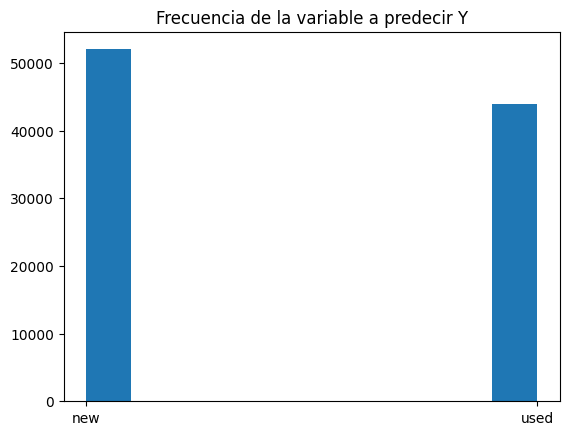

In [64]:
plt.hist(df["Y"])
plt.title("Frecuencia de la variable a predecir Y")
plt.show()

In [68]:
profile = ProfileReport(df, minimal=True)
profile.to_file("output_final.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 949.58it/s]


In [65]:
print(f"Cantidad de variables {len(df.columns)}, cantidad de observaciones {len(df)}")

Cantidad de variables 7, cantidad de observaciones 95955


## Variables a utilizar en el análisis 

En este ejercicio de preparación de los datos se redujo de **47** variables a **7** y se redujo la cantidad de datos de **100003** a **95955** es decir redujeron las observaciones de **4,04%**, el resultado del análisis exploratorio en su etapa inicial, con la limpieza de variables y el final se encuentran en los archivos: *output_initial.html*, *output_clean.html* y *output_initial.html*, del directorio raíz de este repositorio

### Exploraciones adicionales

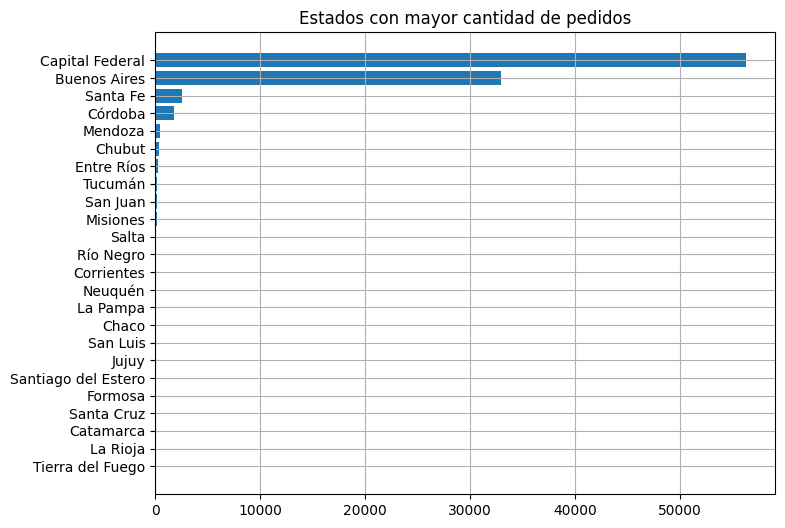

In [66]:
plt.figure(figsize=(8, 6))
df_seller_address_state_name = df.groupby("seller_address_state_name").agg({"seller_address_state_name": "count"})
df_seller_address_state_name = df_seller_address_state_name.rename(columns={"seller_address_state_name": "Estado"})
df_seller_address_state_name = df_seller_address_state_name.sort_values("Estado")
plt.barh(list(df_seller_address_state_name.index), df_seller_address_state_name["Estado"])
plt.title("Estados con mayor cantidad de pedidos")
plt.grid()
plt.show()

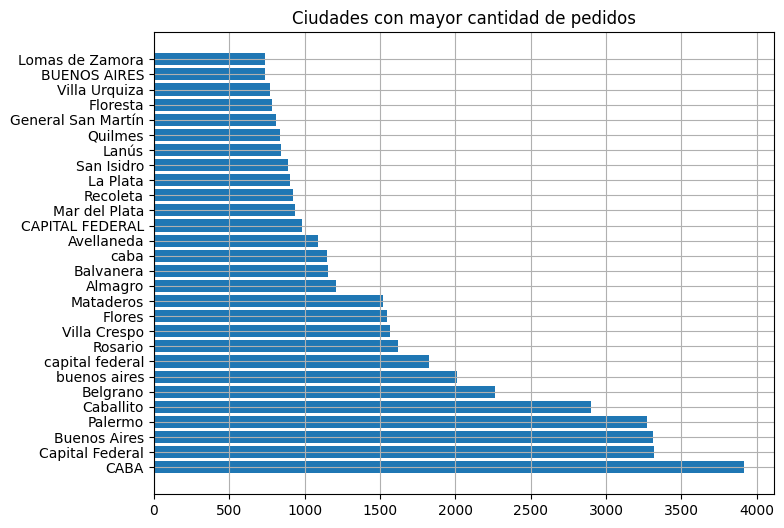

In [67]:
plt.figure(figsize=(8, 6))
df_seller_address_state_name = df.groupby("seller_address_city_name").agg({"seller_address_city_name": "count"})
df_seller_address_state_name = df_seller_address_state_name.rename(columns={"seller_address_city_name": "Ciudad"})
df_seller_address_state_name = df_seller_address_state_name.sort_values("Ciudad", ascending=False)
df_seller_address_state_name = df_seller_address_state_name[0:28]
plt.barh(list(df_seller_address_state_name.index), df_seller_address_state_name["Ciudad"])
plt.title("Ciudades con mayor cantidad de pedidos")
plt.grid()
plt.show()

## Análisis de componentes principales y correlación

Para continuar con nuestro análisis, es importante realizar el tratamiento de normalización y creación de variables dummies. Sin embargo, vamos a separar la variable 'title' del resto de variables, ya que planeamos aplicar técnicas de Procesamiento de Lenguaje Natural (NLP) específicamente en ella. Mientras tanto, seguiremos el enfoque tradicional con las demás variables.

Nuestra hipótesis en este punto es complementar la distribución de probabilidad de un clasificador binario de texto con un clasificador binario tradicional. Esto nos permitirá obtener una visión más completa del comportamiento del problema en estudio.

Además, utilizaremos el Análisis de Componentes Principales (PCA) para obtener una visión global inicial del problema y comprender mejor su estructura y patrones subyacentes.

Igualmente las variables 'seller_address_state_name', 'seller_address_city_name' no se tendran en cuanta por su naturaleza de ser una clase donde se envian los pedidios

In [68]:
df.columns

Index(['listing_type_id', 'price', 'title', 'available_quantity',
       'seller_address_state_name', 'seller_address_city_name', 'Y'],
      dtype='object')

In [86]:
df = df.reset_index(drop=True)

In [92]:
df.to_pickle(FOLDER + "df_all.pkl")

In [70]:
df_num = df[['listing_type_id', 'price', 'available_quantity', 'Y']]

In [71]:
df_text = df[["title", "Y"]]

### Preparación variables numéricas para PCA

In [72]:
df_num.tail()

listing_type_id   price available_quantity     Y
95950          bronze  417.99              False   new
95951            free    30.0              False  used
95952          bronze   239.0              False   new
95953          bronze   600.0              False  used
95954          bronze    50.0              False  used

In [73]:
df_num_d = pd.get_dummies(df_num[["listing_type_id", "available_quantity", "Y"]])

In [74]:
df_num_d.columns

Index(['listing_type_id_bronze', 'listing_type_id_free',
       'listing_type_id_gold', 'listing_type_id_gold_premium',
       'listing_type_id_gold_pro', 'listing_type_id_gold_special',
       'listing_type_id_silver', 'available_quantity_False',
       'available_quantity_1.0', 'Y_new', 'Y_used'],
      dtype='object')

In [75]:
df_num_d["price"] = df_num["price"]

In [76]:
df_num_d["Y"] = df_num["Y"]

In [77]:
df_num_d.head()

listing_type_id_bronze  listing_type_id_free  listing_type_id_gold  \
0                       1                     0                     0   
1                       0                     0                     0   
2                       1                     0                     0   
3                       0                     0                     0   
4                       1                     0                     0   

   listing_type_id_gold_premium  listing_type_id_gold_pro  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   

   listing_type_id_gold_special  listing_type_id_silver  \
0                             0                       0   
1                             0                       1   
2                             0                       0   
3                             0                       1   
4                             0                       0   

   available_quantity_False  available_quantity_1.0  Y_new  Y_used   price  \
0                         1                       0      1       0    80.0   
1                         1                       0      0       1  2650.0   
2                         1                       0      0       1    60.0   
3                         1                       0      1       0   580.0   
4                         1                       0      0       1    30.0   

      Y  
0   new  
1  used  
2  used  
3   new  
4  used

#### Normalización de la variable "price"

In [78]:
scaler = preprocessing.MinMaxScaler()
price = np.array(df_num_d["price"]).reshape(-1,1)
normalizedlist = scaler.fit(list(price))
price = scaler.transform(price)

In [79]:
price

array([[0.00791667],
       [0.26493852],
       [0.0059165 ],
       ...,
       [0.02381802],
       [0.05992109],
       [0.00491642]])

In [80]:
df_num_d["price_norm"] = price
df_num_d = df_num_d.drop(columns=["price"])

In [81]:
df_num_d.tail()

listing_type_id_bronze  listing_type_id_free  listing_type_id_gold  \
95950                       1                     0                     0   
95951                       0                     1                     0   
95952                       1                     0                     0   
95953                       1                     0                     0   
95954                       1                     0                     0   

       listing_type_id_gold_premium  listing_type_id_gold_pro  \
95950                             0                         0   
95951                             0                         0   
95952                             0                         0   
95953                             0                         0   
95954                             0                         0   

       listing_type_id_gold_special  listing_type_id_silver  \
95950                             0                       0   
95951                             0                       0   
95952                             0                       0   
95953                             0                       0   
95954                             0                       0   

       available_quantity_False  available_quantity_1.0  Y_new  Y_used     Y  \
95950                         1                       0      1       0   new   
95951                         1                       0      0       1  used   
95952                         1                       0      1       0   new   
95953                         1                       0      0       1  used   
95954                         1                       0      0       1  used   

       price_norm  
95950    0.041719  
95951    0.002916  
95952    0.023818  
95953    0.059921  
95954    0.004916

In [82]:
df_num_d.columns

Index(['listing_type_id_bronze', 'listing_type_id_free',
       'listing_type_id_gold', 'listing_type_id_gold_premium',
       'listing_type_id_gold_pro', 'listing_type_id_gold_special',
       'listing_type_id_silver', 'available_quantity_False',
       'available_quantity_1.0', 'Y_new', 'Y_used', 'Y', 'price_norm'],
      dtype='object')

In [83]:
num_c_matrix = df_num_d.corr()

/tmp/ipykernel_19968/3341204653.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  num_c_matrix = df_num_d.corr()


In [91]:
num_c_matrix.to_pickle(FOLDER + "df_corr_matrix.pkl")

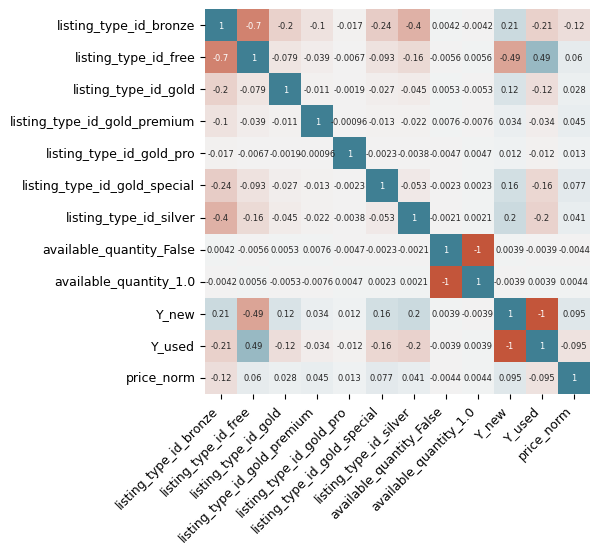

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(num_c_matrix,
            annot=True,
            cbar=False,
            annot_kws={"size": 6},
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation = 45,
                   horizontalalignment = 'right')

ax.tick_params(labelsize = 9)

In [85]:
df_num_d = df_num_d[['listing_type_id_bronze', 'listing_type_id_free',
                     'listing_type_id_gold', 'listing_type_id_gold_premium',
                     'listing_type_id_gold_pro', 'listing_type_id_gold_special',
                     'listing_type_id_silver', 'available_quantity_False',
                     'price_norm', 'Y']]
df_num_d.to_pickle(FOLDER + "df_num_norm.pkl")

Verificando las correlaciones de las diferentes variables no se observan grandes correlaciones salvo, de la variable "listing_type_id_free", aunque la correlación no significa causalidad puede ser una variable que aporte a la clasificación con un conocimiento mas detallado del negocio se podría explicar este comportamientos salvo

####  PCA para la variable "title"

In [90]:
spacy.prefer_gpu()
model = spacy.load("es_core_news_sm")

In [91]:
pipeline = spacy_cleaner.Pipeline(model,
                                  removers.remove_stopword_token,
                                  removers.remove_punctuation_token,
                                  removers.remove_number_token)

In [92]:
def lower_text(text_int):
    temp1 = text_int.split()
    temp2 = [text.lower() for text in temp1]
    text_upper = ' '.join(temp2)
    
    return text_upper   

In [93]:
df_text["title"] = df_text["title"].apply(lambda x: lower_text(x))
df_text["title"] = df_text["title"].apply(lambda x: [x])

In [94]:
# df_text["clean_text"] = 0
# j = 0
# batch = 200
# for i in range(len(df_text)):
#     j += 1
#     temp = pipeline.clean(df_text["title"].iloc[i])
#     df_text["clean_text"].iloc[i] = temp
#     if (j == batch) or (j == len(df_text)):
#         print(i)
#         df_text.to_pickle(FOLDER + "df_text_clean.pkl")
#         j = 0   

In [95]:
df_text = pd.read_pickle(FOLDER + "df_text_clean.pkl")
last_batch = 46794

In [101]:
df_text.tail()

title     Y  \
95950  [pastillas de freno ebc kawasaki kx 125 b2/c1/...   new   
95951  [el corazon de las tinieblas - conrad - biblio...  used   
95952  [juego de toalla y toallon franco valente vari...   new   
95953                           [campera de cuero negra]  used   
95954  [psicodrama y teatro moderno, jean fanchette. f2]  used   

                                             clean_text  
95950  [pastillas freno ebc kawasaki kx b2 c1 d1 83-85]  
95951           [corazon tinieblas conrad biblioteca x]  
95952     [juego toalla toallon franco valente colores]  
95953                             [campera cuero negra]  
95954     [psicodrama teatro moderno jean fanchette f2]

In [97]:
j = 0
batch = 200
for i in list(range(last_batch, len(df_text))):
    j += 1
    temp = pipeline.clean(df_text["title"].iloc[i])
    df_text["clean_text"].iloc[i] = temp
    if (j == batch) or (j == len(df_text)):
        print(i)
        df_text.to_pickle(FOLDER + "df_text_clean.pkl")
        j = 0  

Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 110.03it/s]


46993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 160.27it/s]


47193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 139.54it/s]


47393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 127.72it/s]


47593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 168.57it/s]


47793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 167.95it/s]


47993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 126.56it/s]


48193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 168.36it/s]


48393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 140.40it/s]


48593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.91it/s]


48793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 183.09it/s]


48993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 152.41it/s]


49193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.45it/s]


49393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 148.50it/s]


49593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.14it/s]


49793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 164.95it/s]


49993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 148.68it/s]


50193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 136.63it/s]


50393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 159.97it/s]


50593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 158.09it/s]


50793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 160.23it/s]


50993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 153.18it/s]


51193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 153.02it/s]


51393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 164.60it/s]


51593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 192.74it/s]


51793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.17it/s]


51993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 153.18it/s]


52193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 173.03it/s]


52393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 173.05it/s]


52593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 162.77it/s]


52793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 150.64it/s]


52993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 147.08it/s]


53193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 146.36it/s]


53393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 140.89it/s]


53593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 93.05it/s]


53793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 71.50it/s]


53993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 165.38it/s]


54193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 177.26it/s]


54393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 129.25it/s]


54593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 129.39it/s]


54793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 157.71it/s]


54993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 183.73it/s]


55193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 159.04it/s]


55393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 97.79it/s]


55593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 150.73it/s]


55793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 181.32it/s]


55993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 134.01it/s]


56193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 152.35it/s]


56393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 129.44it/s]


56593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 153.77it/s]


56793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 121.60it/s]


56993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


57193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 135.69it/s]


57393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 182.60it/s]


57593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.01it/s]


57793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 171.97it/s]


57993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 149.74it/s]


58193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 165.08it/s]


58393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 159.29it/s]


58593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 110.86it/s]


58793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 149.79it/s]


58993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 157.68it/s]


59193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 161.13it/s]


59393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 140.23it/s]


59593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 201.17it/s]


59793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 175.45it/s]


59993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 153.84it/s]


60193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 167.57it/s]


60393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 124.82it/s]


60593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 133.90it/s]


60793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.84it/s]


60993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.59it/s]


61193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.46it/s]


61393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 181.55it/s]


61593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 183.02it/s]


61793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 89.92it/s]


61993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 143.17it/s]


62193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 154.78it/s]


62393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 188.12it/s]


62593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 177.94it/s]


62793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 133.42it/s]


62993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 134.36it/s]


63193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 134.52it/s]


63393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 60.03it/s]


63593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 202.28it/s]


63793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 132.22it/s]


63993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 169.37it/s]


64193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.25it/s]


64393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 153.13it/s]


64593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 179.32it/s]


64793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.50it/s]


64993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 143.75it/s]


65193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 148.32it/s]


65393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 152.40it/s]


65593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.65it/s]


65793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 147.60it/s]


65993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 103.55it/s]


66193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 185.07it/s]


66393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 174.28it/s]


66593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 145.75it/s]


66793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.90it/s]


66993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.73it/s]


67193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 137.10it/s]


67393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 165.62it/s]


67593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 122.23it/s]


67793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 159.06it/s]


67993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 152.14it/s]


68193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 162.54it/s]


68393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 184.08it/s]


68593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 148.33it/s]


68793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 131.21it/s]


68993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 145.73it/s]


69193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 172.21it/s]


69393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 122.27it/s]


69593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 165.03it/s]


69793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 181.50it/s]


69993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 141.36it/s]


70193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 100.22it/s]


70393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 161.89it/s]


70593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.77it/s]


70793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.04it/s]


70993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 163.61it/s]


71193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 146.17it/s]


71393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 153.32it/s]


71593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 140.64it/s]


71793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 205.86it/s]


71993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 174.03it/s]


72193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 171.25it/s]


72393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 163.69it/s]


72593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 167.46it/s]


72793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 168.25it/s]


72993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 149.04it/s]


73193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 138.85it/s]


73393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 76.74it/s]


73593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 168.43it/s]


73793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 94.86it/s]


73993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 118.78it/s]


74193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 145.30it/s]


74393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 142.31it/s]


74593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 144.47it/s]


74793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 145.19it/s]


74993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 169.07it/s]


75193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 145.83it/s]


75393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 144.56it/s]


75593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 172.78it/s]


75793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 174.58it/s]


75993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 148.57it/s]


76193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 168.42it/s]


76393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 143.91it/s]


76593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 158.58it/s]


76793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 182.72it/s]


76993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.54it/s]


77193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 176.33it/s]


77393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 143.53it/s]


77593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 171.03it/s]


77793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 171.02it/s]


77993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 147.86it/s]


78193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 136.62it/s]


78393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 150.16it/s]


78593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 133.48it/s]


78793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.14it/s]


78993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 143.64it/s]


79193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 173.66it/s]


79393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 152.88it/s]


79593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 174.87it/s]


79793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 190.99it/s]


79993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 78.80it/s]


80193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 184.09it/s]


80393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 142.12it/s]


80593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 155.30it/s]


80793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 153.55it/s]


80993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.81it/s]


81193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 108.78it/s]


81393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 127.40it/s]


81593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 148.60it/s]


81793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 138.60it/s]


81993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 160.99it/s]


82193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.10it/s]


82393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 167.33it/s]


82593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 145.19it/s]


82793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 135.37it/s]


82993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 171.96it/s]


83193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 152.79it/s]


83393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 166.59it/s]


83593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 158.41it/s]


83793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.29it/s]


83993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 137.06it/s]


84193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 190.39it/s]


84393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 141.22it/s]


84593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 154.91it/s]


84793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 149.50it/s]


84993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 174.29it/s]


85193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 79.53it/s]


85393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 149.36it/s]


85593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 151.60it/s]


85793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 136.57it/s]


85993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 137.00it/s]


86193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s]


86393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 169.65it/s]


86593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 146.17it/s]


86793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 161.80it/s]


86993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 125.00it/s]


87193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 126.57it/s]


87393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 163.72it/s]


87593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 172.70it/s]


87793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 170.49it/s]


87993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 142.42it/s]


88193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 157.56it/s]


88393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 113.72it/s]


88593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 148.86it/s]


88793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 156.15it/s]


88993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 149.48it/s]


89193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 183.20it/s]


89393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 170.00it/s]


89593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 157.98it/s]


89793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 174.63it/s]


89993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 139.55it/s]


90193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 105.13it/s]


90393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 162.12it/s]


90593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 166.51it/s]


90793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 136.88it/s]


90993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 158.32it/s]


91193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 143.49it/s]


91393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 144.76it/s]


91593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 154.07it/s]


91793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 176.63it/s]


91993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 141.85it/s]


92193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 109.61it/s]


92393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 171.62it/s]


92593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 135.82it/s]


92793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 163.53it/s]


92993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 158.01it/s]


93193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 110.25it/s]


93393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 180.38it/s]


93593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 140.59it/s]


93793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 164.61it/s]


93993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 145.16it/s]


94193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 141.62it/s]


94393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 159.03it/s]


94593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 66.03it/s]


94793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 167.64it/s]


94993


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 140.17it/s]


95193


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 139.44it/s]


95393


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 152.83it/s]


95593


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 160.29it/s]


95793


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 138.50it/s]


In [98]:
df_text.tail()

title     Y  \
95950  [pastillas de freno ebc kawasaki kx 125 b2/c1/...   new   
95951  [el corazon de las tinieblas - conrad - biblio...  used   
95952  [juego de toalla y toallon franco valente vari...   new   
95953                           [campera de cuero negra]  used   
95954  [psicodrama y teatro moderno, jean fanchette. f2]  used   

                                             clean_text  
95950  [pastillas freno ebc kawasaki kx b2 c1 d1 83-85]  
95951           [corazon tinieblas conrad biblioteca x]  
95952     [juego toalla toallon franco valente colores]  
95953                             [campera cuero negra]  
95954     [psicodrama teatro moderno jean fanchette f2]

In [102]:
df_text.to_pickle(FOLDER + "df_text_clean.pkl")